# Imports

In [13]:
%matplotlib widget

In [2]:
from translocation_model import (SC2R1Loop, SC2R2Loops, DiscSpiral, 
                                 DefectiveSC2R, DefectiveDiscSpiral)

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
savefig = False # Indicate if we want to save the figures

# Simple Gillespie trajectories

## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 1 loop

![](SC_2R_1_loop_kinetic_scheme.jpg)

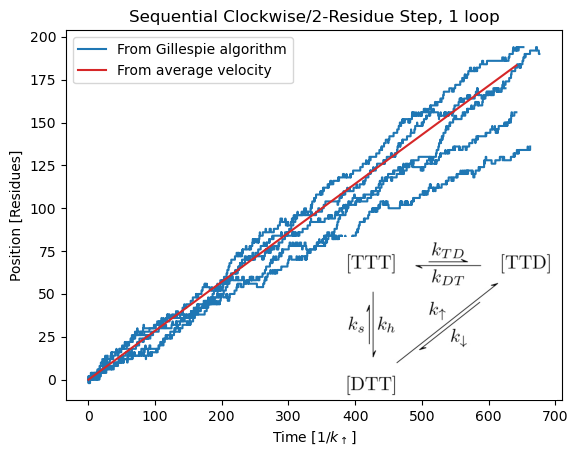

In [4]:
SC_2R_1_loop = SC2R1Loop()
trajectories = SC_2R_1_loop.gillespie(n_simulations=5, 
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_1_loop.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)
plt.show()

### 2 loops

![](SC_2R_2_different_loops_kinetic_scheme.jpg)

TODO create image

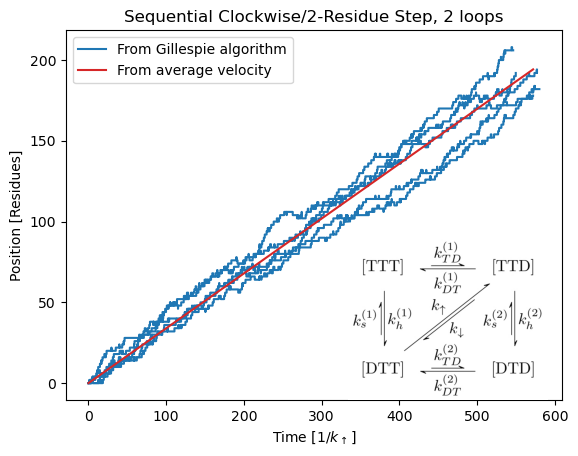

In [5]:
SC_2R_2_loops = SC2R2Loops()
trajectories = SC_2R_2_loops.gillespie(n_simulations=5,
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_2_loops.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 2 loops"
)
plt.show()

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

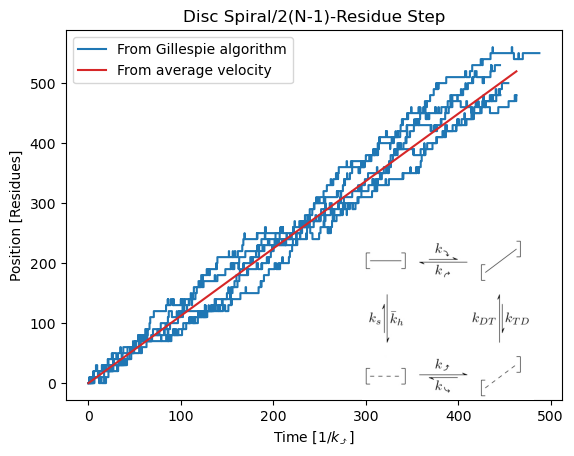

In [6]:
disc_spiral = DiscSpiral()
trajectories = disc_spiral.gillespie(n_simulations=5,
    cumulative_sums={'position': 'displacement', 'ATP': 'ATP'})
ax = disc_spiral.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_⤴$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="Disc_spiral_kinetic_scheme.jpg",
    title="Disc Spiral/2(N-1)-Residue Step"
)
plt.show()

# Experiments

## Relation between ATP/ADP concentrations ratio and velocity

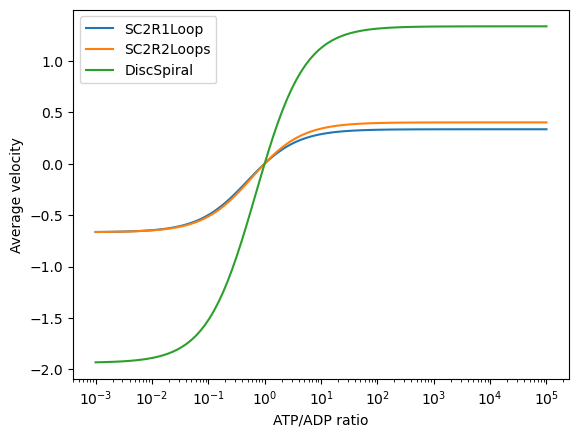

In [7]:
models = [SC2R1Loop(), SC2R2Loops(), DiscSpiral()]
ratios = np.logspace(-3, 5, 100) * SC_2R_1_loop.equilibrium_ATP_ADP_ratio
velocities = {model: [] for model in models}
for ratio in ratios:
    for model in models:
        model.ATP_ADP_ratio = ratio
        velocities[model].append(model.average_velocity())

for model in models:
    plt.plot(ratios, velocities[model], label=model.__class__.__name__)
plt.xscale('log')
plt.xlabel("ATP/ADP ratio")
plt.ylabel("Average velocity")
plt.legend()
plt.show()

## Sequential Clockwise/2-Residue Step, comparison between 1 and 2 loops

In [8]:
# 1 loop and 2 loops models
SC_2R_1_loop = SC2R1Loop()
SC_2R_2_loops = SC2R2Loops()

ATP_ADP_ratios = np.logspace(-1, 1, 10)
for ATP_ADP_ratio in ATP_ADP_ratios:
    print("ATP/ADP:", ATP_ADP_ratio)
    SC_2R_1_loop.ATP_ADP_ratio = ATP_ADP_ratio
    SC_2R_2_loops.ATP_ADP_ratio = ATP_ADP_ratio
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_1_loop.kinetic_scheme.nodes(data=True)})
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_2_loops.kinetic_scheme.nodes(data=True)})



ATP/ADP: 0.1
{'TTT': 0.08333333333333333, 'DTT': 0.33333333333333337, 'TTD': 0.5833333333333334}
{'TTT': 0.03736263736263736, 'DTT': 0.07692307692307691, 'TTD': 0.33406593406593404, 'DTD': 0.5516483516483516}
ATP/ADP: 0.16681005372000587
{'TTT': 0.12508063787386262, 'DTT': 0.3333333333333333, 'TTD': 0.541586028792804}
{'TTT': 0.06285529607164458, 'DTT': 0.11117482042019278, 'TTD': 0.3284880760923012, 'DTD': 0.4974818074158614}
ATP/ADP: 0.2782559402207124
{'TTT': 0.17876891510895462, 'DTT': 0.3333333333333333, 'TTD': 0.48789775155771203}
{'TTT': 0.10180497553128667, 'DTT': 0.15165730349483372, 'TTD': 0.31601578414408676, 'DTD': 0.43052193682979273}
ATP/ADP: 0.46415888336127786
{'TTT': 0.24070663630827838, 'DTT': 0.33333333333333326, 'TTD': 0.4259600303583882}
{'TTT': 0.1549318394055542, 'DTT': 0.1940076963112737, 'TTD': 0.2947146725000551, 'DTD': 0.356345791783117}
ATP/ADP: 0.774263682681127
{'TTT': 0.30380826716022774, 'DTT': 0.3333333333333333, 'TTD': 0.3628583995064389}
{'TTT': 0.217

## Add potential

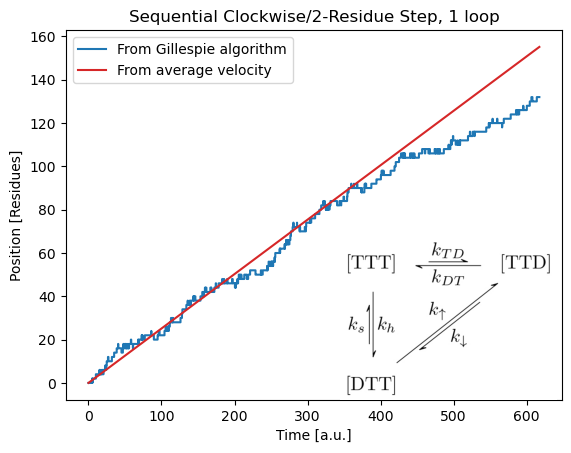

In [9]:
# If positive, potential increases when chaperone goes up, i.e. it favors going
# down.
potential_over_temperature = 0.1
SC_2R_1_loop = SC2R1Loop()
for _, _, attributes in SC_2R_1_loop.kinetic_scheme.edges(data=True):
    if 'position' in attributes and attributes['position'] > 0:
        old_rate = attributes['rate']
        attributes['rate'] = (
            lambda old_rate=old_rate: 
                old_rate() * np.exp(-potential_over_temperature))
    elif 'position' in attributes and attributes['position'] < 0:
        old_rate = attributes['rate']
        attributes['rate'] = (
            lambda old_rate=old_rate: 
                old_rate() * np.exp(potential_over_temperature))

SC_2R_1_loop_position = SC_2R_1_loop.gillespie(
    n_steps=1000, 
    n_simulations=1, 
    cumulative_sums={'position': 'displacement'})

ax = SC_2R_1_loop.plot_position_evolution(
    SC_2R_1_loop_position[['timestamp', 'position']],
    time_unit=r"a.u.", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)

## Defective protomer

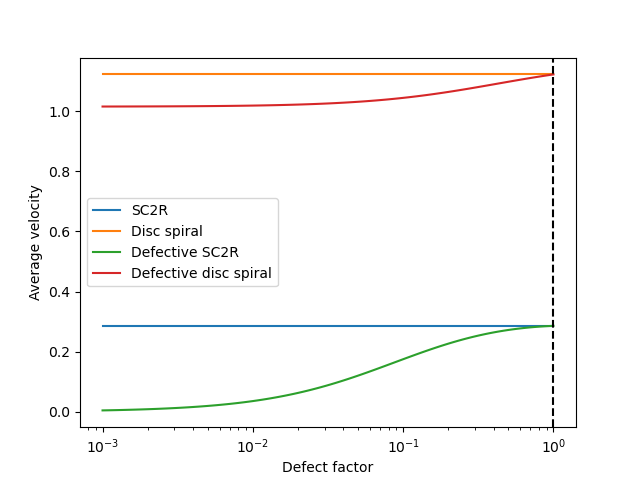

Max velocity for SC2R: 0.2857142857142857
Max velocity for Disc spiral: 1.122661122661123
Max velocity for Defective SC2R: 0.28571428571428586
Max velocity for Defective disc spiral: 1.1226611226611232


In [14]:
sc2r = SC2R1Loop()
defective_sc2r = DefectiveSC2R()
disc_spiral = DiscSpiral()
defective_disc_spiral = DefectiveDiscSpiral()

defect_factors = np.logspace(-3, 0, 100)
velocities = {
    'SC2R': [],
    'Disc spiral': [],
    'Defective SC2R': [],
    'Defective disc spiral': [],
}
for defect_factor in defect_factors:
    defective_sc2r.defect_factor = defect_factor
    defective_disc_spiral.defect_factor = defect_factor
    velocities['SC2R'].append(sc2r.average_velocity())
    velocities['Disc spiral'].append(disc_spiral.average_velocity())
    velocities['Defective SC2R'].append(defective_sc2r.average_velocity())
    velocities['Defective disc spiral'].append(
        defective_disc_spiral.average_velocity())

fig, ax = plt.subplots()
for model in velocities:
    ax.plot(defect_factors, velocities[model], label=model)
ax.axvline(1, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel("Defect factor")
ax.set_ylabel("Average velocity")
ax.legend()
plt.show()
# print max velocity
print("Max velocity for SC2R:", max(velocities['SC2R']))
print("Max velocity for Disc spiral:", max(velocities['Disc spiral']))
print("Max velocity for Defective SC2R:", max(velocities['Defective SC2R']))
print("Max velocity for Defective disc spiral:", 
      max(velocities['Defective disc spiral']))


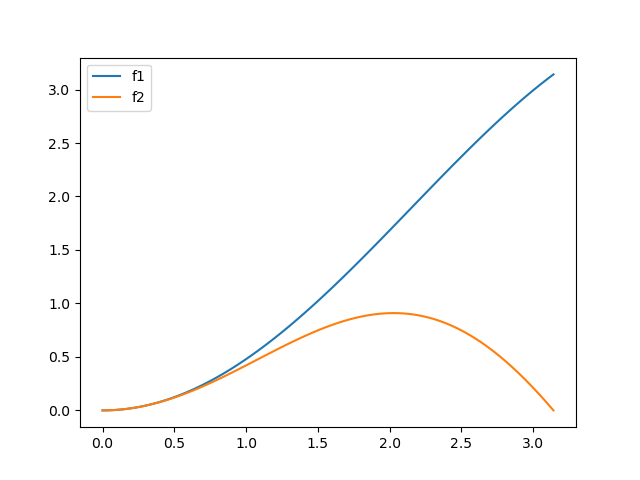

In [15]:
import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, np.pi, 100)
tau = np.linspace(0.5, 10, 100)

def f1(x, tau, beta):
    return np.sin(x * tau) * x * beta
def f2(x, tau, beta):
    return np.sin(x * beta) * x * tau


fig, ax = plt.subplots()
controls = iplt.plot(x, f1, tau=tau, beta=(1, 10, 100), label="f1")
iplt.plot(x, f2, controls=controls, label="f2")
_ = plt.legend()
plt.show()